In [1]:
# Import library
# %pip install seaborn
# %pip install openpyxl
# %pip install mlxtend
# %pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Cleaning
Renaming df columns & adding two new columns:
- Year
- Quarter

In [2]:
df = pd.read_csv(r'/Users/William/Documents/GitHub/ZZSC9020-Group-M/data/master_normalised.csv')
df= df.rename(columns={
     'quarter': "Time_Period",
     'Total Demand': "Electricity_Demand",
     'GDP (AUD, Millions)':"GDP",
     'Population (000,s)':"Population",
     'Coal_Price (PCOALAUUSDM)':"Coal_Price",
     'Premium unleaded petrol (95 RON) (cpl)':"Premium_Unleaded_Petrol",
     'Regular unleaded petrol (91 RON) (cpl)':"Regular_Unleaded_Petrol",
     'Automotive diesel (cpl)':"Automotive_Diesel",
     'Automotive LPG (cpl)':"Automotive_LPG",
     'Temperature(max)':"Temperature_Max",
     'Temperature(avg)':"Temperature_Avg",
     'Temperature(min)':"Temperature_Min",
     'electricity_price':"Electricity_Price",
     'renewable_energy':"Renewables_Production",
     'oil_price': 'Oil_Price'
})
df.columns.tolist()

df['Time_Period'] = pd.to_datetime(df['Time_Period'])
# Extract the year
df['Year'] = df['Time_Period'].dt.year
# Extract the quarter
df['Quarter'] = df['Time_Period'].dt.quarter
df.head()

,Time_Period,Electricity_Demand,GDP,Population,Coal_Price,Premium_Unleaded_Petrol,Regular_Unleaded_Petrol,Automotive_Diesel,Automotive_LPG,Temperature_Max,Temperature_Avg,Temperature_Min,Electricity_Price,Renewables_Production,Oil_Price,Year,Quarter
0,2010-01-01,0.930894,0.000000,0.000000,0.558774,0.275,0.363636,0.234043,0.228571,0.969492,0.999016,0.971787,0.303922,0.000000,0.652967,2010,1
1,2010-04-01,0.860334,0.118536,0.018352,0.632759,0.350,0.431818,0.340426,0.171429,0.510734,0.279528,0.173197,0.250000,0.027860,0.640241,2010,2
2,2010-07-01,1.000000,0.141274,0.038033,0.564323,0.250,0.318182,0.297872,0.000000,0.183051,0.135827,0.155956,0.196078,0.055720,0.617716,2010,3
3,2010-10-01,0.737070,0.232885,0.056494,0.719280,0.275,0.363636,0.319149,0.200000,0.606780,0.670276,0.611285,0.142157,0.083580,0.734558,2010,4
4,2011-01-01,0.858217,0.120926,0.082599,1.000000,0.575,0.613636,0.595745,0.542857,0.912994,0.981299,0.978840,0.088235,0.111441,0.848923,2011,1


## Correlation Analysis

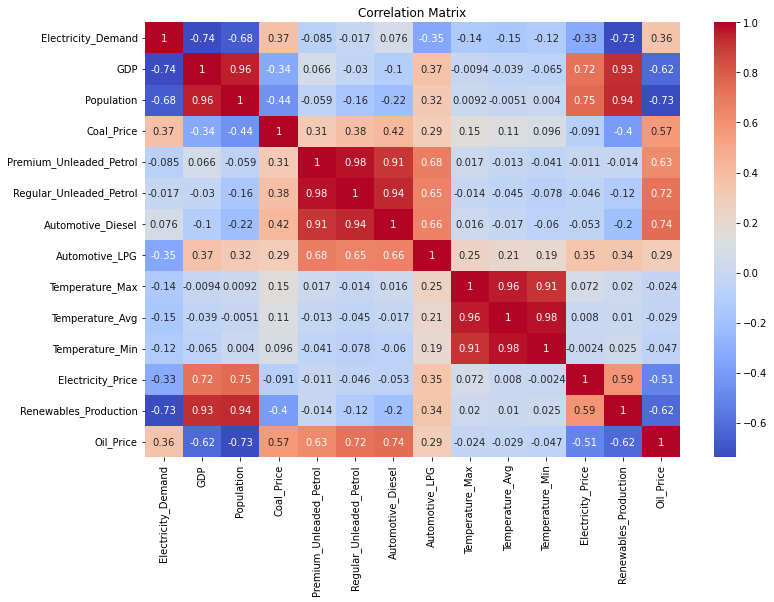

Electricity_Demand         1.000000
Coal_Price                 0.371817
Oil_Price                  0.357952
Automotive_Diesel          0.076427
Regular_Unleaded_Petrol   -0.017037
Premium_Unleaded_Petrol   -0.085003
Temperature_Min           -0.123126
Temperature_Max           -0.138913
Temperature_Avg           -0.152526
Electricity_Price         -0.327437
Automotive_LPG            -0.346566
Population                -0.676495
Renewables_Production     -0.732432
GDP                       -0.738298
Name: Electricity_Demand, dtype: float64


In [3]:
# Setting 'Time_Period' as index
df.set_index('Time_Period', inplace=True)

# Exclude Year and Quarter columns from correlation analysis
df_analysis = df.drop(columns=['Year', 'Quarter'], errors='ignore')

# Calculate correlation matrix
corr_matrix = df_analysis.corr()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Display correlation values with Electricity_Demand specifically
electricity_demand_correlation = corr_matrix['Electricity_Demand'].sort_values(ascending=False)
print(electricity_demand_correlation)

## Train/Test Split
- 2010-2018 as training
- 2019-2020 as testing
- Average temperature used for temperature

In [4]:
# Splitting the data according to the specified years and quarters
train = df[(df['Year'] < 2019)]
test = df[((df['Year'] >= 2019) & (df['Year'] < 2021))]

def test_split(features: list = None):
    _train = df[(df['Year'] < 2019)]
    _test = df[((df['Year'] >= 2019) & (df['Year'] < 2021))]

    if features:
        _X_train = _train[features]
        _y_train = _train['Electricity_Demand']
        _X_test = _test[features]
        _y_test = _test['Electricity_Demand']
    else:
        _X_train = _train.drop(['Electricity_Demand', 'Year', 'Quarter', 'Temperature_Min', 'Temperature_Max'], axis=1)
        _y_train = _train['Electricity_Demand']
        _X_test = _test.drop(['Electricity_Demand', 'Year', 'Quarter','Temperature_Min', 'Temperature_Max'], axis=1)
        _y_test = _test['Electricity_Demand']
    return _X_train, _y_train, _X_test, _y_test

def train_model2(in_model):
    # Fit the model on the training data
    in_model.fit(X_train, y_train)

    # Get training set scores
    y_pred_train = in_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    train_r2 = r2_score(y_train, y_pred_train)
    
    # Predict on the test set
    y_pred = in_model.predict(X_test)
    
    # Calculate the RMSE for the test set
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Calculate the R-squared value for the test set
    test_r2 = r2_score(y_test, y_pred)
    
    # print(f"{in_model.__class__.__name__} Train RMSE, R-squared: {train_rmse:6.4f}, {train_r2:6.4f}")
    # print(f"{in_model.__class__.__name__} Test  RMSE, R-squared: {test_rmse:6.4f}, {test_r2:6.4f}")
    return in_model, test_rmse, test_r2, train_rmse, train_r2
    
def find_better_model(model_class, params):
    min_rmse, best_model, best_param_set, best_r2 = None, None, None, None
    results = []
    for param_set in itertools.product(*params.values()):
        kw_args = dict(zip(params.keys(), param_set))
        # print(f'{model_class.__name__} | ' + ', '.join([f'{k}: {v}' for k, v in kw_args.items()]))
        model = model_class(**kw_args)
        out_model, rmse, r2, train_rmse, train_r2 = train_model2(model)
        results.append({**kw_args, 'test_rmse': rmse, 'test_r2': r2, 'train_rmse': train_rmse, 'train_r2': train_r2})
        if min_rmse is None or rmse < min_rmse:
            min_rmse = rmse
            best_r2 = r2
            best_model = out_model
            best_param_set = kw_args
    print(f'Best model with params {model_class.__name__}({best_param_set})\nRMSE: {min_rmse:0.4f}\nR-squared: {best_r2:0.4f}')
    return best_model, pd.DataFrame(results), min_rmse

def scatterplot(data, x, y, x2, y2, hue, style, title, title2):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
    sns.scatterplot(data=data, x=x, y=y, hue=hue, style=style, ax=ax1)
    ax1.title.set_text(title)
    sns.scatterplot(data=data, x=x2, y=y2, hue=hue, style=style, ax=ax2)
    ax2.title.set_text(title2)
    sns.scatterplot(data=data, x=x, y=x2, hue=hue, style=style, ax=ax3)
    ax3.title.set_text('Training')
    sns.scatterplot(data=data, x=y, y=y2, hue=hue, style=style, ax=ax4)
    ax4.title.set_text('Test')
    plt.show()
    # RMSE vs. Number of Features
    # plt.figure(figsize=(10, 6))
    # plt.plot(range(1, len(rmse_values) + 1), rmse_values, marker='o', linestyle='-')
    # plt.title(f'RMSE vs. Number of Features ({model_name})')
    # plt.xlabel('Number of Features')
    # plt.ylabel('RMSE')
    # plt.grid(True)
    # plt.show()

def plot_test(in_model):
    plt.figure(figsize=(12, 6))
    plt.title(f'{in_model.__class__.__name__} Model')
    plt.scatter(test.reset_index()['Time_Period'], y_test)
    plt.plot(test.reset_index()['Time_Period'], in_model.predict(X_test), color='black')
    plt.show()

def plot_full(in_model):
    plt.figure(figsize=(12, 6))
    plt.title(f'{in_model.__class__.__name__} Model')
    plt.scatter(train.reset_index()['Time_Period'], y_train)
    plt.scatter(test.reset_index()['Time_Period'], y_test)
    plt.plot(train.reset_index()['Time_Period'], in_model.predict(X_train), color='black')
    plt.plot(test.reset_index()['Time_Period'], in_model.predict(X_test), color='green')
    plt.ylim(ymin=0)
    plt.show()

def find_best_features(model_class, hyper_parameters, features = None, min_features: int = 1, max_features: int = 5):
    global X_train, y_train, X_test, y_test
    if not features:
        features = ['GDP', 'Population', 'Coal_Price', 'Regular_Unleaded_Petrol', 'Automotive_LPG', 'Temperature_Avg', 'Electricity_Price', 'Renewables_Production', 'Oil_Price']
    combinations = []
    for i in range(min_features, max_features + 1):
        combinations.extend(itertools.combinations(features, i))
    print(len(combinations), 'combinations')

    results = []
    min_rmse = None
    for i, columns in enumerate(combinations, start=1):
        X_train, y_train, X_test, y_test = test_split(list(columns))
        model, df_results, best_rmse = find_better_model(model_class, hyper_parameters)
        mean_rmse = df_results['test_rmse'].mean()
        results.append([columns, best_rmse, mean_rmse])
        print(f'{i:3d}  {best_rmse:6.4f} {columns}')
    result = pd.DataFrame(results, columns = ['features', 'min_rmse', 'mean_rmse'])
    return result

Best model with params GradientBoostingRegressor({'random_state': 0, 'n_estimators': 150, 'learning_rate': 0.15, 'max_depth': 4})
RMSE: 0.0645
R-squared: 0.5706


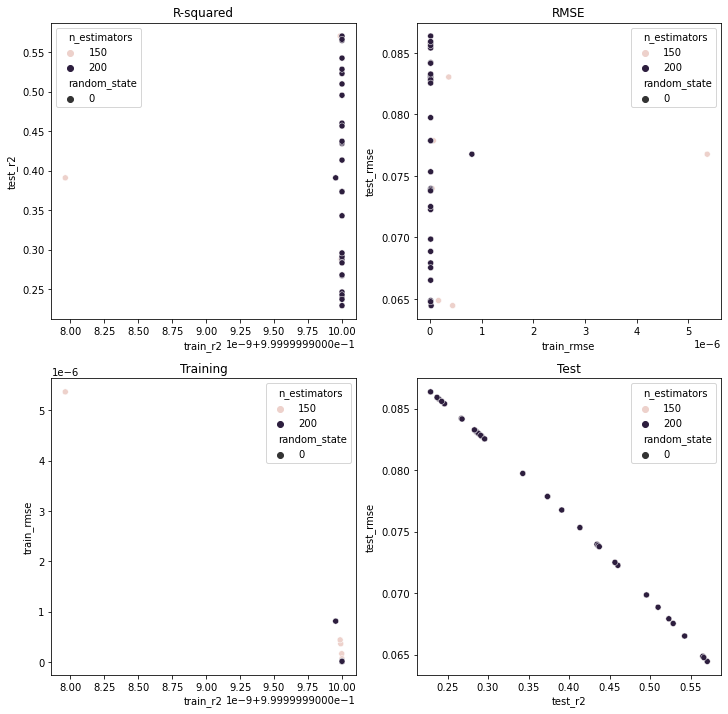

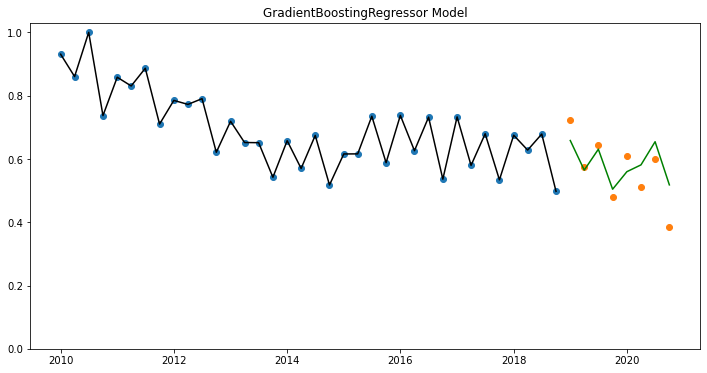

In [5]:
X_train, y_train, X_test, y_test = test_split()
model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
                'random_state': [0],
                'n_estimators': [150, 200],
                'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3],
                'max_depth': [4, 5, 6, 7, 10]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='random_state', title='R-squared', title2='RMSE')
plot_full(model)

In [6]:
# best_features = find_best_features(GradientBoostingRegressor, {
#                 'random_state': [0],
#                 'n_estimators': [150, 200],
#                 'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3],
#                 'max_depth': [4, 5, 6]
#                 },
#                 min_features=1, max_features=6)
# best_features['num_features'] = best_features['features'].apply(lambda x: len(x))
# best_features.sort_values('min_rmse')

In [7]:
# best_features.iloc[335]['features']

Best model with params GradientBoostingRegressor({'random_state': 11, 'n_estimators': 150, 'learning_rate': 0.195, 'max_depth': 3})
RMSE: 0.0498
R-squared: 0.7435


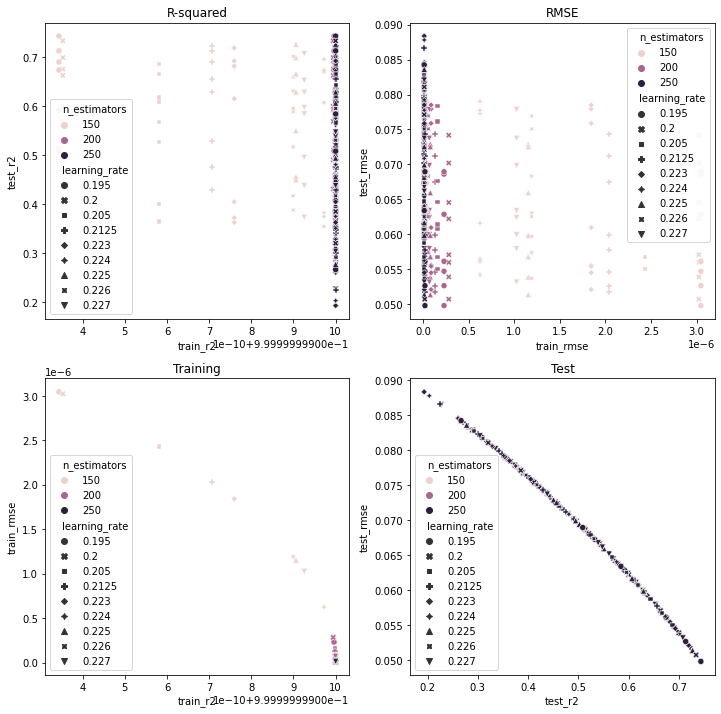

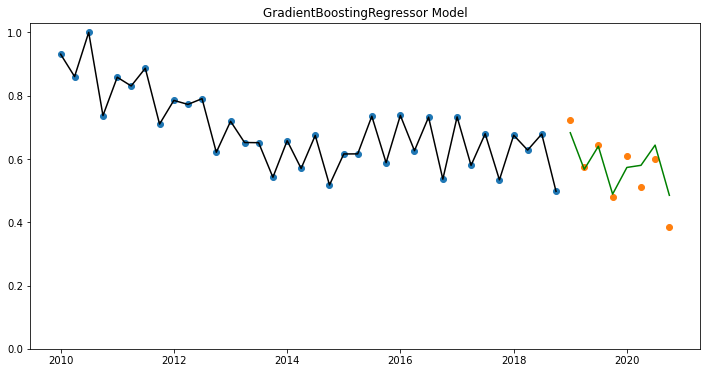

In [8]:
X_train, y_train, X_test, y_test = test_split(['Population',
 'Coal_Price',
 'Automotive_LPG',
 'Temperature_Avg',
 'Electricity_Price'])
model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
                'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
                'n_estimators': [150, 200, 250],
                'learning_rate': [0.195, 0.2, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
                'max_depth': [3, 4, 5]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='learning_rate', title='R-squared', title2='RMSE')
plot_full(model)

Best model with params GradientBoostingRegressor({'random_state': 3, 'n_estimators': 150, 'learning_rate': 0.19, 'max_depth': 3})
RMSE: 0.0490
R-squared: 0.7518


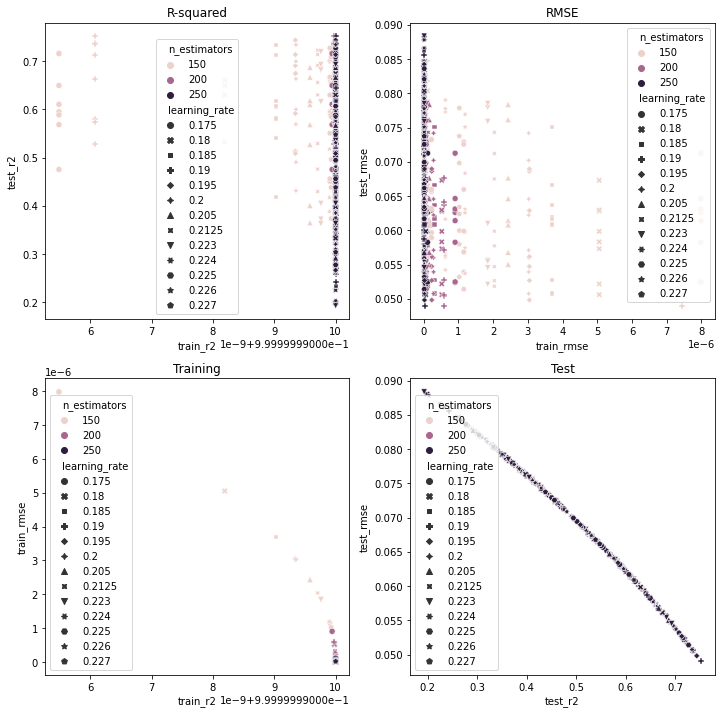

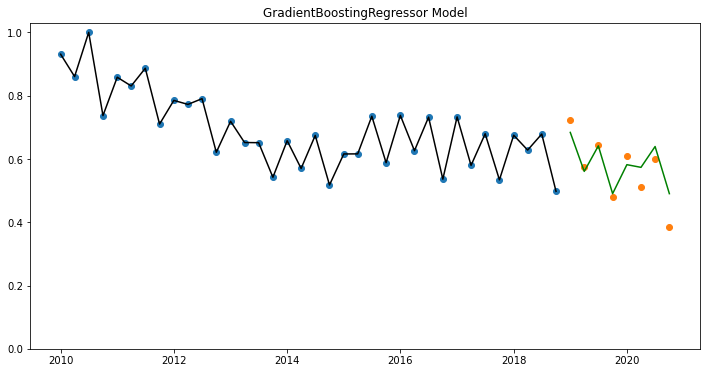

In [9]:
X_train, y_train, X_test, y_test = test_split(['Population',
 'Coal_Price',
 'Automotive_LPG',
 'Temperature_Avg',
 'Electricity_Price'])
model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
                'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
                'n_estimators': [150, 200, 250],
                'learning_rate': [0.175, 0.18, 0.185, 0.190, 0.195, 0.2, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
                'max_depth': [3, 4, 5]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='learning_rate', title='R-squared', title2='RMSE')
plot_full(model)

Best model with params GradientBoostingRegressor({'random_state': 23, 'n_estimators': 150, 'learning_rate': 0.1875, 'max_depth': 3})
RMSE: 0.0474
R-squared: 0.7682


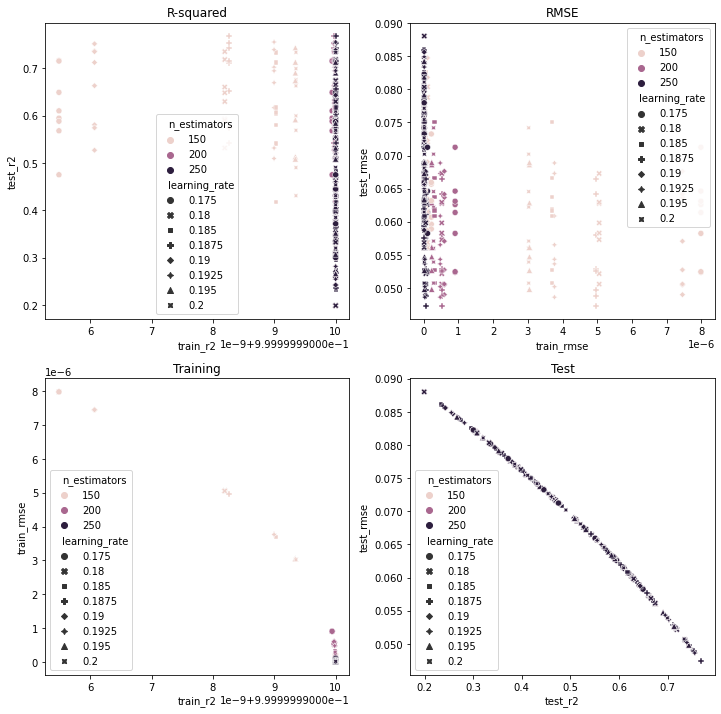

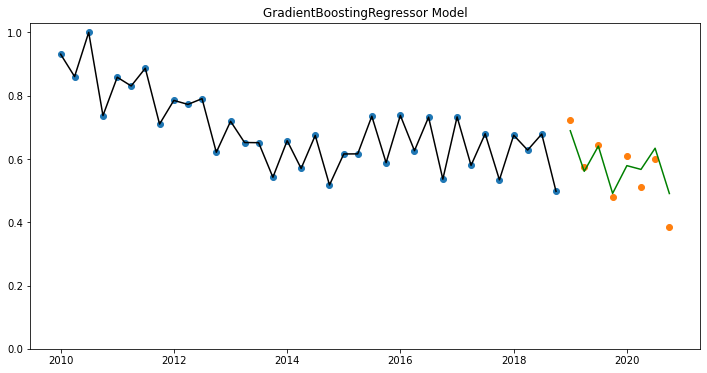

In [10]:
X_train, y_train, X_test, y_test = test_split(['Population',
 'Coal_Price',
 'Automotive_LPG',
 'Temperature_Avg',
 'Electricity_Price'])
model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
                'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
                'n_estimators': [150, 200, 250],
                'learning_rate': [0.175, 0.18, 0.185, 0.1875, 0.190, 0.1925, 0.195, 0.2], #, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
                'max_depth': [3, 4, 5]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='learning_rate', title='R-squared', title2='RMSE')
plot_full(model)

Features: ['Population', 'Coal_Price', 'Automotive_LPG', 'Temperature_Avg', 'Electricity_Price']
Best model with params GradientBoostingRegressor({'random_state': 23, 'n_estimators': 150, 'learning_rate': 0.188, 'max_depth': 3})
RMSE: 0.0472
R-squared: 0.7697


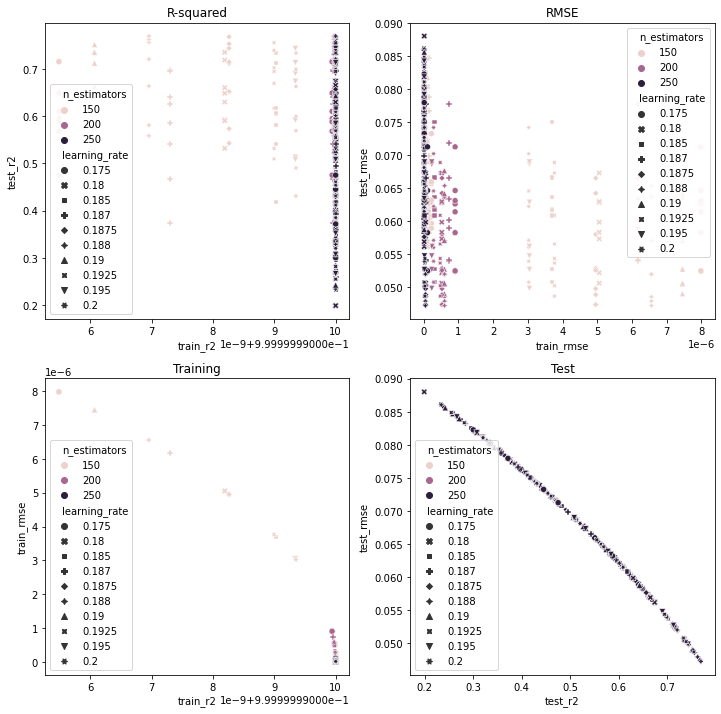

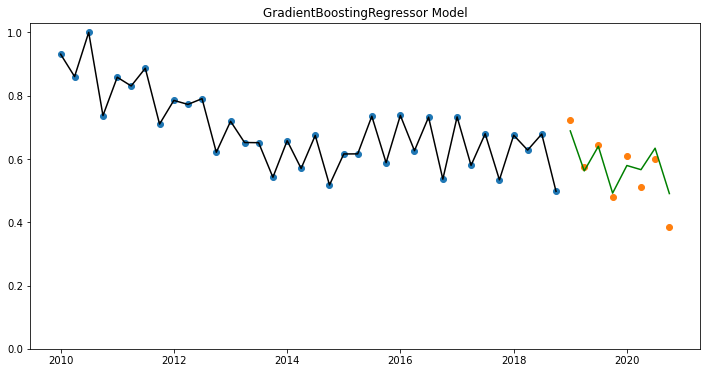

In [11]:
features = ['Population',
 'Coal_Price',
 'Automotive_LPG',
 'Temperature_Avg',
 'Electricity_Price']
X_train, y_train, X_test, y_test = test_split(features)
print(f'Features: {features}')
model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
                'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
                'n_estimators': [150, 200, 250],
                'learning_rate': [0.175, 0.18, 0.185, 0.187, 0.1875, 0.188, 0.188, 0.190, 0.1925, 0.195, 0.2], #, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
                'max_depth': [3, 4, 5]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='learning_rate', title='R-squared', title2='RMSE')
plot_full(model)

# Champion Model
Tweaked the learning rate further but found no improvement over 0.188.

This is the champion model.

Features: ['Population', 'Coal_Price', 'Automotive_LPG', 'Temperature_Avg', 'Electricity_Price']
Best model with params GradientBoostingRegressor({'random_state': 23, 'n_estimators': 150, 'learning_rate': 0.188, 'max_depth': 3})
RMSE: 0.0472
R-squared: 0.7697


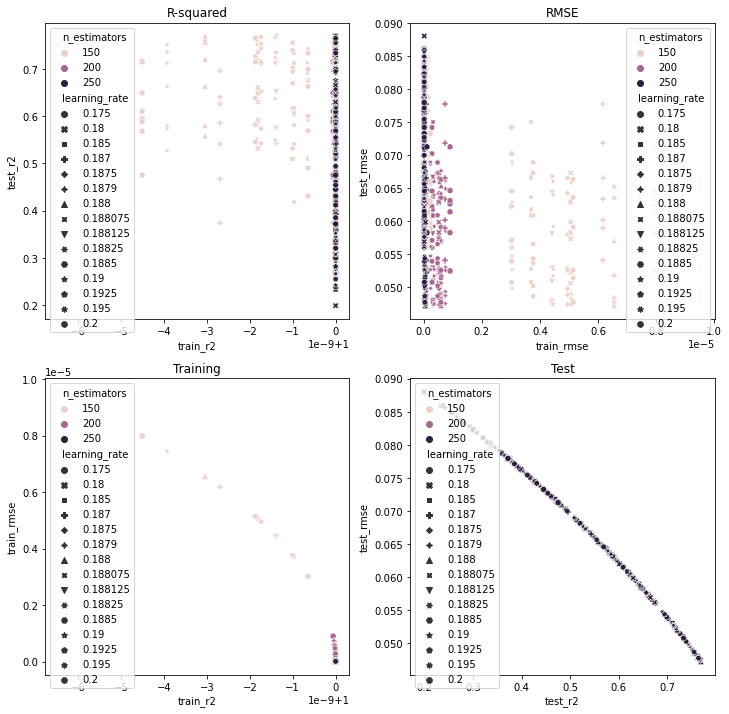

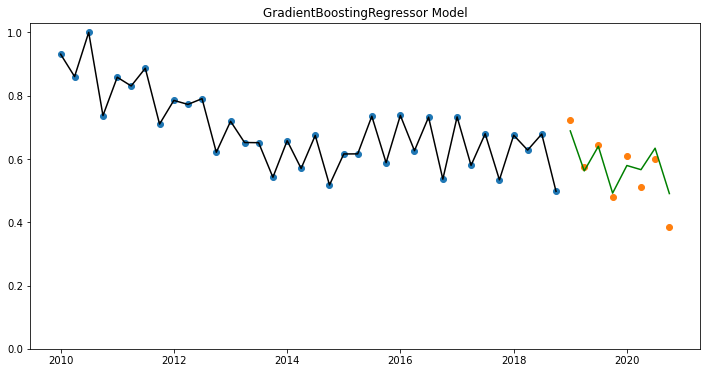

In [12]:
features = ['Population',
 'Coal_Price',
 'Automotive_LPG',
 'Temperature_Avg',
 'Electricity_Price']
X_train, y_train, X_test, y_test = test_split(features)
print(f'Features: {features}')
model, df_results, best_rmse = find_better_model(GradientBoostingRegressor, {
                'random_state': [0, 3, 5, 7, 11, 13, 19, 23],
                'n_estimators': [150, 200, 250],
                'learning_rate': [0.175, 0.18, 0.185, 0.187, 0.1875, 0.1879, 0.188, 0.188075, 0.188125, 0.18825, 0.1885, 0.190, 0.1925, 0.195, 0.2], #, 0.205, 0.2125, 0.223, 0.224, 0.225, 0.226, 0.227], # , 0.2375, 0.25, 0.275, 0.2875, 0.3, 0.03125],
                'max_depth': [3, 4, 5]
                })
scatterplot(data=df_results, x='train_r2', y='test_r2', x2='train_rmse', y2='test_rmse', hue='n_estimators', style='learning_rate', title='R-squared', title2='RMSE')
plot_full(model)

# Time Series Forecasting Model

## Population

In [13]:
# Split the data into training and testing sets

train_pop=pd.DataFrame(train.iloc[:,2]).reset_index()
test_pop=pd.DataFrame(test.iloc[:,2]).reset_index()
test_pop

,Time_Period,Population
0,2019-01-01,0.894792
1,2019-04-01,0.913741
2,2019-07-01,0.941744
3,2019-10-01,0.964081
4,2020-01-01,0.993196
5,2020-04-01,0.998970
6,2020-07-01,0.994660
7,2020-10-01,0.993955


In [14]:
temp_series=df['Population']
temp_series

Time_Period
2010-01-01    0.000000
2010-04-01    0.018352
2010-07-01    0.038033
2010-10-01    0.056494
2011-01-01    0.082599
2011-04-01    0.101900
2011-07-01    0.127057
2011-10-01    0.151292
2012-01-01    0.183469
2012-04-01    0.208572
2012-07-01    0.235788
2012-10-01    0.261297
2013-01-01    0.292472
2013-04-01    0.315541
2013-07-01    0.340508
2013-10-01    0.361544
2014-01-01    0.390930
2014-04-01    0.409770
2014-07-01    0.433408
2014-10-01    0.454390
2015-01-01    0.482935
2015-04-01    0.502020
2015-07-01    0.525956
2015-10-01    0.547724
2016-01-01    0.579929
2016-04-01    0.603649
2016-07-01    0.632546
2016-10-01    0.656293
2017-01-01    0.690531
2017-04-01    0.712543
2017-07-01    0.738974
2017-10-01    0.757651
2018-01-01    0.790940
2018-04-01    0.813034
2018-07-01    0.841253
2018-10-01    0.862588
2019-01-01    0.894792
2019-04-01    0.913741
2019-07-01    0.941744
2019-10-01    0.964081
2020-01-01    0.993196
2020-04-01    0.998970
2020-07-01    0.994660

+ indicates a strong negative autocorrelation in the time series. Current value will always not less than previous value
+ pattern in the ACF plot suggests that the time series can be modeled using an Autoregressive Moving Average (ARMA) process, not ARIMA process.

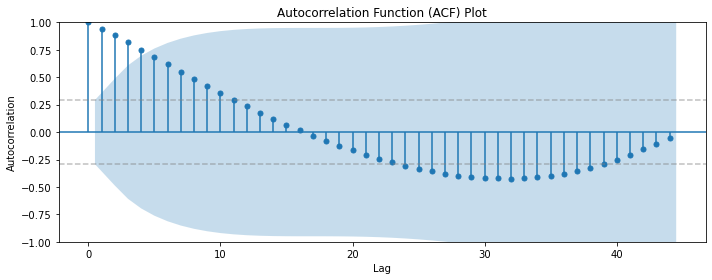

In [15]:
# Create the ACF plot
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(temp_series, lags=44, ax=ax)
ax.set_title('Autocorrelation Function (ACF) Plot')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

# Add confidence interval lines
conf_int = 1.96 / np.sqrt(len(temp_series))
ax.axhline(y=conf_int, linestyle='--', color='gray', alpha=0.5)
ax.axhline(y=-conf_int, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

/Users/william/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


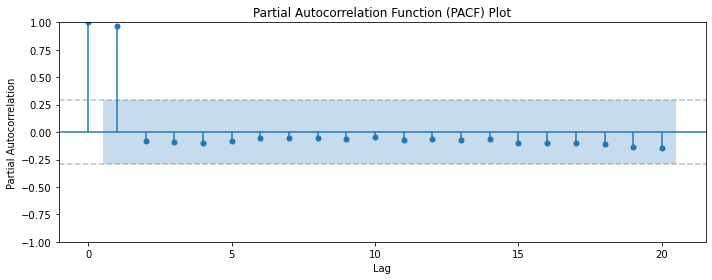

In [16]:
# Create the PACF plot to identify the appropriatre autoregressive AR order 
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(temp_series, lags=20, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF) Plot')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')

# Add confidence interval lines
conf_int = 1.96 / np.sqrt(len(temp_series))
ax.axhline(y=conf_int, linestyle='--', color='gray', alpha=0.5)
ax.axhline(y=-conf_int, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

In [17]:
# Fit ARIMA model to training data
model = ARIMA(train_pop['Population'], order=(1, 1, 4))  # Autogressive component is 4 (current value depends on past 12 months.Blue area crosses the bar at 4), Integrated Component 1 (current value depends on last quarter), Moving Average Component 4 (there are suspected seasonal patterns with a period of 12 month)
results = model.fit()

/Users/william/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/william/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
# Forecast future electricity usage
forecast_horizon = 20  # forecast horizon (20 quarter)
forecast = results.forecast(steps=forecast_horizon)

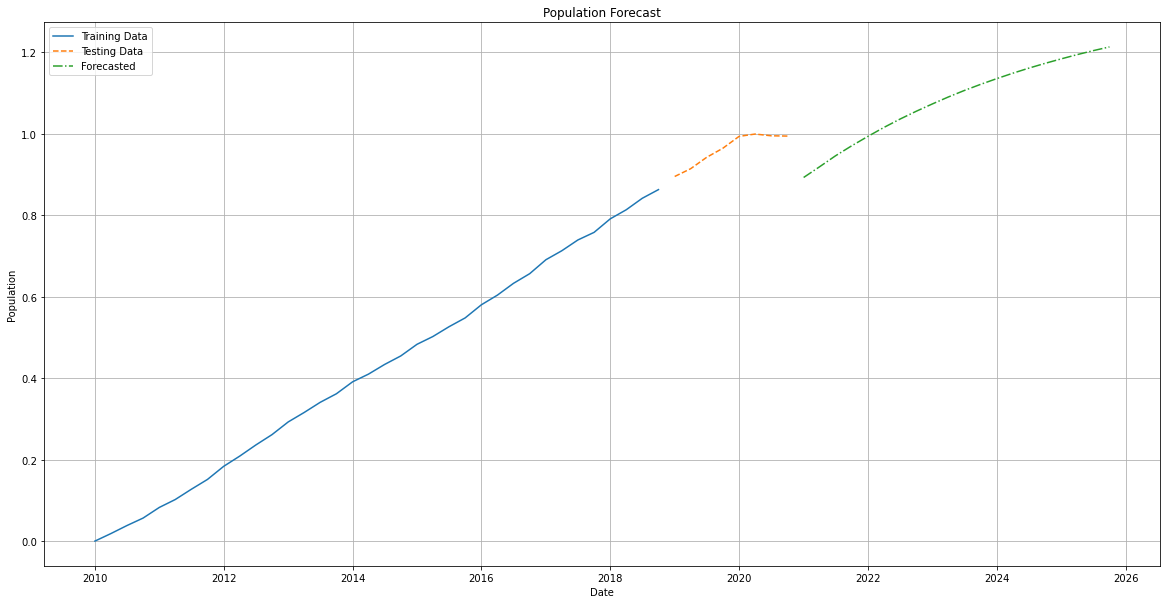

In [19]:
# Convert the 'quarter' column to datetime format with no timezone information
train_pop['Time_Period'] = pd.to_datetime(train_pop['Time_Period'], errors='coerce').dt.tz_localize(None)
test_pop['Time_Period'] = pd.to_datetime(test_pop['Time_Period'], errors='coerce').dt.tz_localize(None)

# Plot historical data, training data, and forecasted values
plt.figure(figsize=(20, 10))

plt.plot(train_pop['Time_Period'], train_pop['Population'], label='Training Data')
plt.plot(test_pop['Time_Period'], test_pop['Population'], label='Testing Data', linestyle='--')

# Define the start date for the forecasted period
start_date = test_pop['Time_Period'].dropna().iloc[-1]  # Assuming 'quarter' column contains date values and handling missing values

# Plot the forecasted period with date values
forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon+1, freq='QS')[1:]
plt.plot(forecast_dates, forecast, label='Forecasted', linestyle='-.')  # Use forecast_dates for x-axis

plt.xlabel('Date')
plt.ylabel('Population')
plt.title('Population Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
df_pop=pd.DataFrame({'Time_Period':forecast_dates,'Population':forecast})
df_pop

,Time_Period,Population
36,2021-01-01,0.892348
37,2021-04-01,0.918500
38,2021-07-01,0.945620
39,2021-10-01,0.970223
40,2022-01-01,0.993355
41,2022-04-01,1.015103
42,2022-07-01,1.035550
43,2022-10-01,1.054774
44,2023-01-01,1.072848
45,2023-04-01,1.089840


## Coal Price

In [64]:
# Split the data into training and testing sets
train_coal=pd.DataFrame(train.iloc[:,3]).reset_index()
test_coal=pd.DataFrame(test.iloc[:,3]).reset_index()
test_coal

,Time_Period,Coal_Price
0,2019-01-01,0.590062
1,2019-04-01,0.393322
2,2019-07-01,0.231878
3,2019-10-01,0.211780
4,2020-01-01,0.227268
5,2020-04-01,0.072938
6,2020-07-01,0.000000
7,2020-10-01,0.181443


In [65]:
temp_series=df['Coal_Price']
temp_series

Time_Period
2010-01-01    0.558774
2010-04-01    0.632759
2010-07-01    0.564323
2010-10-01    0.719280
2011-01-01    1.000000
2011-04-01    0.907461
2011-07-01    0.904197
2011-10-01    0.833333
2012-01-01    0.807485
2012-04-01    0.592009
2012-07-01    0.479251
2012-10-01    0.448763
2013-01-01    0.544016
2013-04-01    0.471454
2013-07-01    0.361282
2013-10-01    0.421750
2014-01-01    0.373034
2014-04-01    0.310466
2014-07-01    0.252415
2014-10-01    0.188740
2015-01-01    0.189686
2015-04-01    0.136099
2015-07-01    0.134805
2015-10-01    0.054240
2016-01-01    0.029569
2016-04-01    0.040362
2016-07-01    0.222426
2016-10-01    0.568131
2017-01-01    0.423606
2017-04-01    0.393102
2017-07-01    0.558459
2017-10-01    0.610633
2018-01-01    0.678589
2018-04-01    0.682428
2018-07-01    0.841969
2018-10-01    0.675940
2019-01-01    0.590062
2019-04-01    0.393322
2019-07-01    0.231878
2019-10-01    0.211780
2020-01-01    0.227268
2020-04-01    0.072938
2020-07-01    0.000000

+ The gradual decay to 0 at lag 6 indicates the presence of short-term autocorrelation in the time series.
+ The oscillation in the ACF plot after lag 6 suggests the presence of a seasonal or cyclic pattern in the time series.

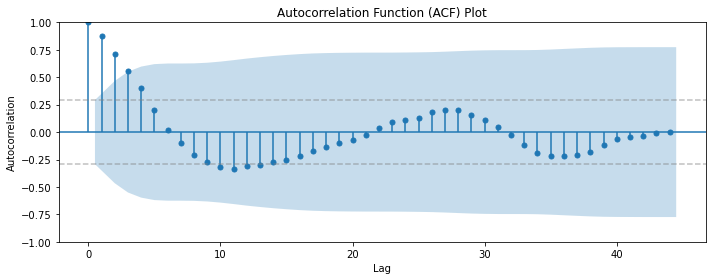

In [66]:
# Create the ACF plot
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(temp_series, lags=44, ax=ax)
ax.set_title('Autocorrelation Function (ACF) Plot')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

# Add confidence interval lines
conf_int = 1.96 / np.sqrt(len(temp_series))
ax.axhline(y=conf_int, linestyle='--', color='gray', alpha=0.5)
ax.axhline(y=-conf_int, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

/Users/william/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


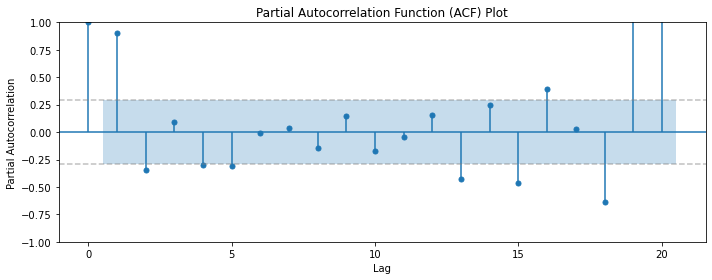

In [70]:
# Create the PACF plot
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(temp_series, lags=20, ax=ax)
ax.set_title('Partial Autocorrelation Function (ACF) Plot')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')

# Add confidence interval lines
conf_int = 1.96 / np.sqrt(len(temp_series))
ax.axhline(y=conf_int, linestyle='--', color='gray', alpha=0.5)
ax.axhline(y=-conf_int, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

In [24]:
# Fit ARIMA model to training data
model = ARIMA(train_coal['Coal_Price'], order=(6, 0, 4))  # Autogressive component is 6 (current value depends on past 18 months), Integrated Component 0 (there is no persistent upward or downward movement in the series over time), Moving Average Component 4 (there are seasonal patterns with a period of 12 month)
results = model.fit()

/Users/william/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/william/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# Forecast future electricity usage
forecast_horizon = 20  # forecast horizon (20 quarter)
forecast = results.forecast(steps=forecast_horizon)

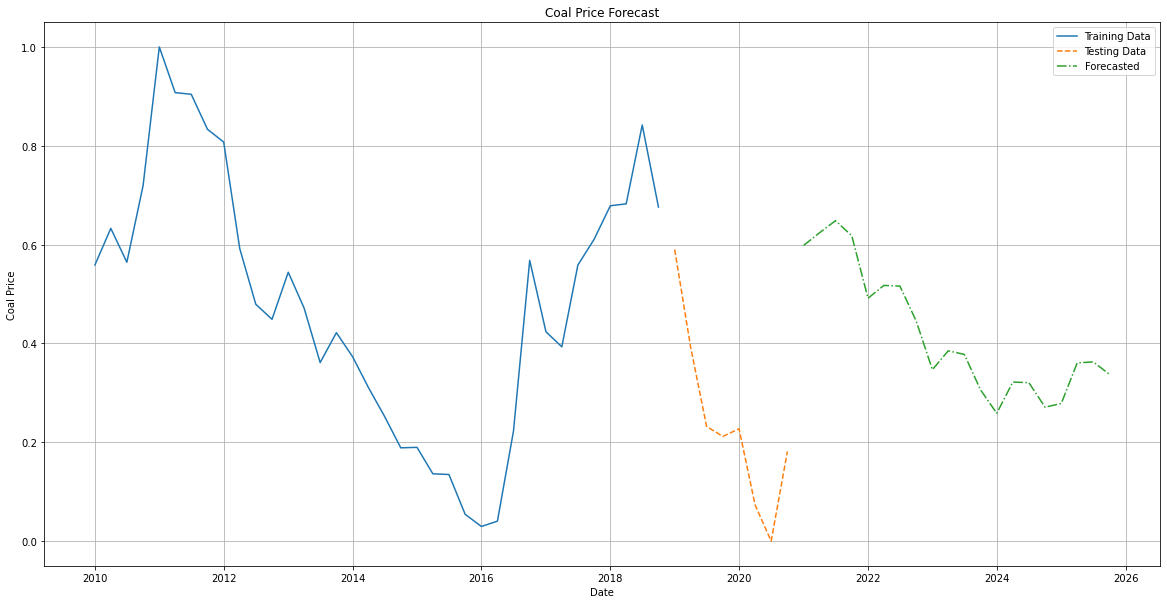

In [26]:
# Convert the 'quarter' column to datetime format with no timezone information
train_coal['Time_Period'] = pd.to_datetime(train_coal['Time_Period'], errors='coerce').dt.tz_localize(None)
test_coal['Time_Period'] = pd.to_datetime(test_coal['Time_Period'], errors='coerce').dt.tz_localize(None)

# Plot historical data, training data, and forecasted values
plt.figure(figsize=(20, 10))

plt.plot(train_coal['Time_Period'], train_coal['Coal_Price'], label='Training Data')
plt.plot(test_coal['Time_Period'], test_coal['Coal_Price'], label='Testing Data', linestyle='--')

# Define the start date for the forecasted period
start_date = test_coal['Time_Period'].dropna().iloc[-1]  # Assuming 'quarter' column contains date values and handling missing values

# Plot the forecasted period with date values
forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon+1, freq='QS')[1:]
plt.plot(forecast_dates, forecast, label='Forecasted', linestyle='-.')  # Use forecast_dates for x-axis

plt.xlabel('Date')
plt.ylabel('Coal Price')
plt.title('Coal Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
df_coal=pd.DataFrame({'Time_Period':forecast_dates,'Coal_Price':forecast})
df_coal

,Time_Period,Coal_Price
36,2021-01-01,0.598256
37,2021-04-01,0.623917
38,2021-07-01,0.648405
39,2021-10-01,0.617756
40,2022-01-01,0.491422
41,2022-04-01,0.517375
42,2022-07-01,0.515945
43,2022-10-01,0.445549
44,2023-01-01,0.346872
45,2023-04-01,0.385020


## Automotive LPG

In [71]:
# Split the data into training and testing sets
train_LPG=pd.DataFrame(train.iloc[:,7]).reset_index()
test_LPG=pd.DataFrame(test.iloc[:,7]).reset_index()
test_LPG

,Time_Period,Automotive_LPG
0,2019-01-01,0.514286
1,2019-04-01,0.628571
2,2019-07-01,0.514286
3,2019-10-01,0.485714
4,2020-01-01,0.657143
5,2020-04-01,0.457143
6,2020-07-01,0.457143
7,2020-10-01,0.428571


In [72]:
temp_series=df['Automotive_LPG']
temp_series

Time_Period
2010-01-01    0.228571
2010-04-01    0.171429
2010-07-01    0.000000
2010-10-01    0.200000
2011-01-01    0.542857
2011-04-01    0.514286
2011-07-01    0.428571
2011-10-01    0.400000
2012-01-01    0.600000
2012-04-01    0.542857
2012-07-01    0.257143
2012-10-01    0.600000
2013-01-01    0.457143
2013-04-01    0.285714
2013-07-01    0.542857
2013-10-01    0.742857
2014-01-01    1.000000
2014-04-01    0.657143
2014-07-01    0.571429
2014-10-01    0.457143
2015-01-01    0.171429
2015-04-01    0.142857
2015-07-01    0.057143
2015-10-01    0.142857
2016-01-01    0.171429
2016-04-01    0.228571
2016-07-01    0.142857
2016-10-01    0.285714
2017-01-01    0.485714
2017-04-01    0.457143
2017-07-01    0.400000
2017-10-01    0.657143
2018-01-01    0.742857
2018-04-01    0.685714
2018-07-01    0.742857
2018-10-01    0.828571
2019-01-01    0.514286
2019-04-01    0.628571
2019-07-01    0.514286
2019-10-01    0.485714
2020-01-01    0.657143
2020-04-01    0.457143
2020-07-01    0.457143

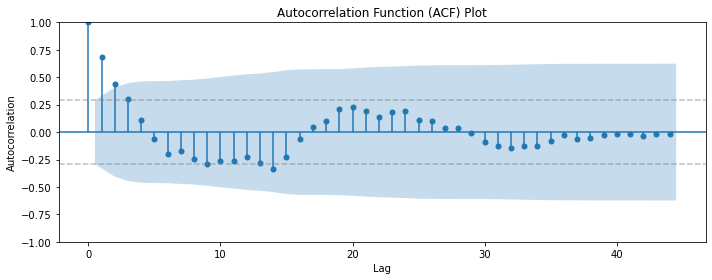

In [73]:
# Create the ACF plot
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(temp_series, lags=44, ax=ax)
ax.set_title('Autocorrelation Function (ACF) Plot')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

# Add confidence interval lines
conf_int = 1.96 / np.sqrt(len(temp_series))
ax.axhline(y=conf_int, linestyle='--', color='gray', alpha=0.5)
ax.axhline(y=-conf_int, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()


/Users/william/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


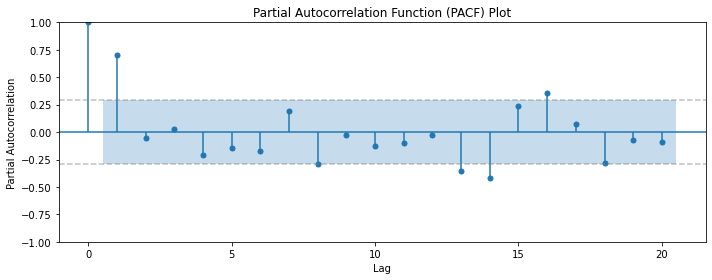

In [76]:
# Create the PACF plot
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(temp_series, lags=20, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF) Plot')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')

# Add confidence interval lines
conf_int = 1.96 / np.sqrt(len(temp_series))
ax.axhline(y=conf_int, linestyle='--', color='gray', alpha=0.5)
ax.axhline(y=-conf_int, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

In [87]:
# Fit ARIMA model to training data
model = ARIMA(train_LPG['Automotive_LPG'], order=(5, 0, 4))  # Autogressive component is 6 (current value depends on past 18 months), Integrated Component 0 (there is no persistent upward or downward movement in the series over time), Moving Average Component 4 (there are seasonal patterns with a period of 12 month)
results = model.fit()

/Users/william/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [88]:
# Forecast future electricity usage
forecast_horizon = 20  # forecast horizon (20 quarter)
forecast = results.forecast(steps=forecast_horizon)

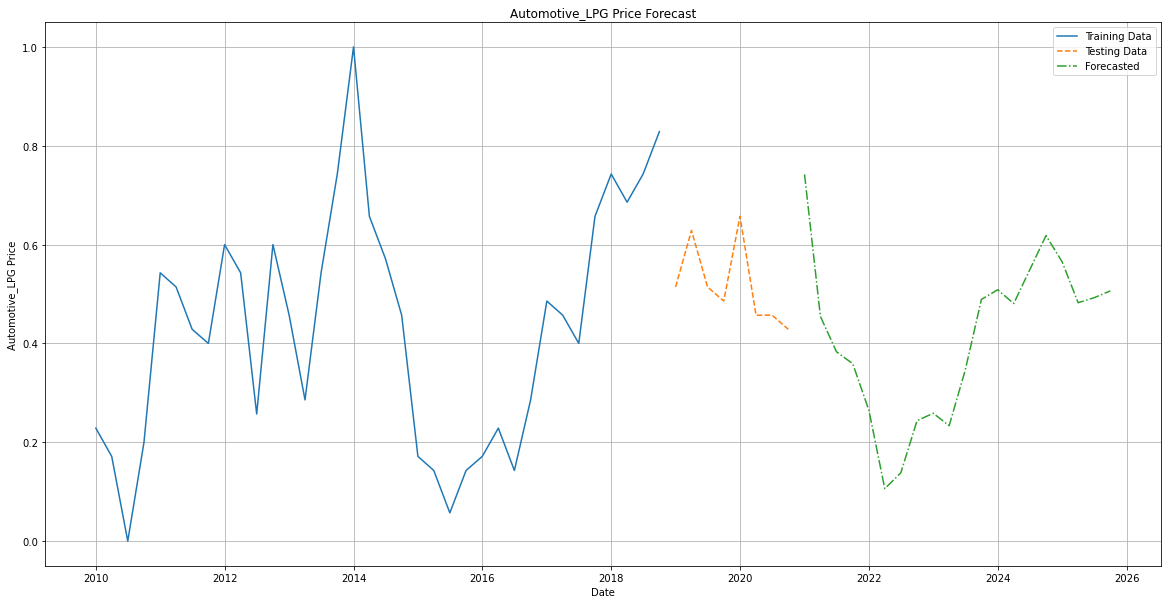

In [89]:
# Convert the 'quarter' column to datetime format with no timezone information
train_LPG['Time_Period'] = pd.to_datetime(train_LPG['Time_Period'], errors='coerce').dt.tz_localize(None)
test_LPG['Time_Period'] = pd.to_datetime(test_LPG['Time_Period'], errors='coerce').dt.tz_localize(None)

# Plot historical data, training data, and forecasted values
plt.figure(figsize=(20, 10))

plt.plot(train_LPG['Time_Period'], train_LPG['Automotive_LPG'], label='Training Data')
plt.plot(test_LPG['Time_Period'], test_LPG['Automotive_LPG'], label='Testing Data', linestyle='--')

# Define the start date for the forecasted period
start_date = test_LPG['Time_Period'].dropna().iloc[-1]  # Assuming 'quarter' column contains date values and handling missing values

# Plot the forecasted period with date values
forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon+1, freq='QS')[1:]
plt.plot(forecast_dates, forecast, label='Forecasted', linestyle='-.')  # Use forecast_dates for x-axis

plt.xlabel('Date')
plt.ylabel('Automotive_LPG Price')
plt.title('Automotive_LPG Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
df_LPG=pd.DataFrame({'Time_Period':forecast_dates,'Automotive_LPG':forecast})
df_LPG

,Time_Period,Automotive_LPG
36,2021-01-01,0.756530
37,2021-04-01,0.601579
38,2021-07-01,0.596852
39,2021-10-01,0.517489
40,2022-01-01,0.464997
41,2022-04-01,0.450242
42,2022-07-01,0.446095
43,2022-10-01,0.444929
44,2023-01-01,0.444601
45,2023-04-01,0.444509


## Temperature Avg

In [90]:
# Split the data into training and testing sets
train_temp=pd.DataFrame(train.iloc[:,9]).reset_index()
test_temp=pd.DataFrame(test.iloc[:,9]).reset_index()
test_temp

,Time_Period,Temperature_Avg
0,2019-01-01,0.979331
1,2019-04-01,0.255906
2,2019-07-01,0.081693
3,2019-10-01,0.707677
4,2020-01-01,0.882874
5,2020-04-01,0.200787
6,2020-07-01,0.080709
7,2020-10-01,0.687008


In [91]:
temp_series=df['Temperature_Avg']
temp_series

Time_Period
2010-01-01    0.999016
2010-04-01    0.279528
2010-07-01    0.135827
2010-10-01    0.670276
2011-01-01    0.981299
2011-04-01    0.199803
2011-07-01    0.076772
2011-10-01    0.687008
2012-01-01    0.884843
2012-04-01    0.243110
2012-07-01    0.104331
2012-10-01    0.756890
2013-01-01    0.943898
2013-04-01    0.190945
2013-07-01    0.158465
2013-10-01    0.645669
2014-01-01    0.896654
2014-04-01    0.296260
2014-07-01    0.033465
2014-10-01    0.717520
2015-01-01    0.882874
2015-04-01    0.179134
2015-07-01    0.000000
2015-10-01    0.729331
2016-01-01    0.920276
2016-04-01    0.333661
2016-07-01    0.116142
2016-10-01    0.689961
2017-01-01    1.000000
2017-04-01    0.216535
2017-07-01    0.080709
2017-10-01    0.712598
2018-01-01    0.929134
2018-04-01    0.246063
2018-07-01    0.033465
2018-10-01    0.691929
2019-01-01    0.979331
2019-04-01    0.255906
2019-07-01    0.081693
2019-10-01    0.707677
2020-01-01    0.882874
2020-04-01    0.200787
2020-07-01    0.080709

+ A gradually decaying pattern, where the coefficients decrease towards zero as the lag increases, indicates a short-term memory or a weakening influence of past values on the current value
+ ACF exhibits a repeating pattern at fixed lags (every 4 quarters), it indicates the presence of seasonality or cyclic behavior in the time series.
+ There is no sharp cutoff suggests a moving average (MA) process is not appropriate
+ A gradual tailing off indicates an autoregressive (AR) process, where the current value is influenced by a weighted sum of past values.

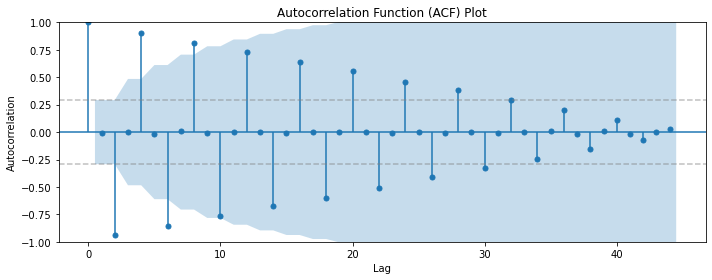

In [92]:
# Create the ACF plot
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(temp_series, lags=44, ax=ax)
ax.set_title('Autocorrelation Function (ACF) Plot')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

# Add confidence interval lines
conf_int = 1.96 / np.sqrt(len(temp_series))
ax.axhline(y=conf_int, linestyle='--', color='gray', alpha=0.5)
ax.axhline(y=-conf_int, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

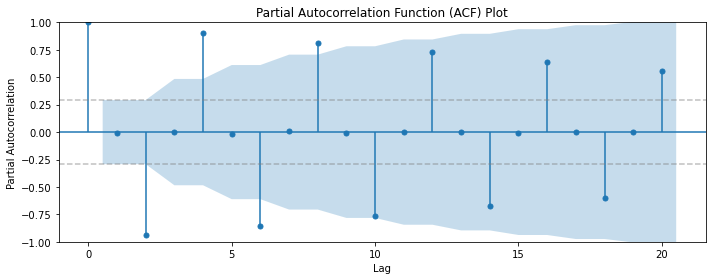

In [93]:
# Create the PACF plot
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(temp_series, lags=20, ax=ax)
ax.set_title('Partial Autocorrelation Function (ACF) Plot')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')

# Add confidence interval lines
conf_int = 1.96 / np.sqrt(len(temp_series))
ax.axhline(y=conf_int, linestyle='--', color='gray', alpha=0.5)
ax.axhline(y=-conf_int, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

In [38]:
model = ARIMA(train_temp['Temperature_Avg'], order=(4, 1, 0))  # Autogressive component is 4 (current value depends on past 12 months), Integrated Component 1 (seasonal data), Moving Average Component 1 (there are seasonal patterns with a period of 12 month)
results = model.fit()

In [39]:
# Forecast future electricity usage
forecast_horizon = 20  # forecast horizon (20 quarter)
forecast = results.forecast(steps=forecast_horizon)

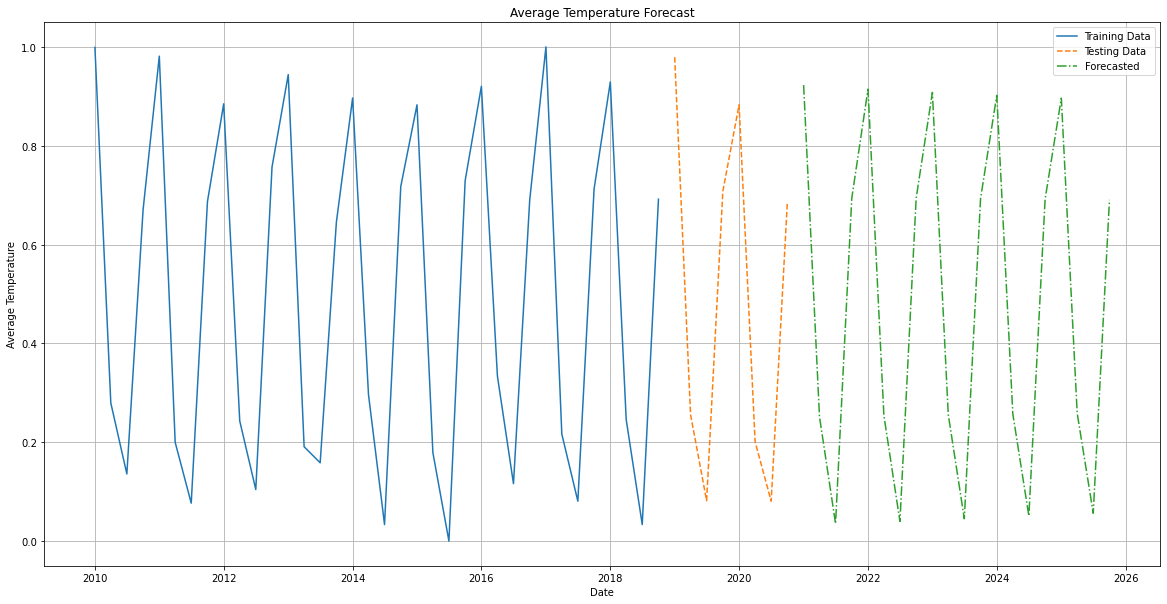

In [40]:
# Convert the 'quarter' column to datetime format with no timezone information
train_temp['Time_Period'] = pd.to_datetime(train_temp['Time_Period'], errors='coerce').dt.tz_localize(None)
test_temp['Time_Period'] = pd.to_datetime(test_temp['Time_Period'], errors='coerce').dt.tz_localize(None)

# Plot historical data, training data, and forecasted values
plt.figure(figsize=(20, 10))

plt.plot(train_temp['Time_Period'], train_temp['Temperature_Avg'], label='Training Data')
plt.plot(test_temp['Time_Period'], test_temp['Temperature_Avg'], label='Testing Data', linestyle='--')

# Define the start date for the forecasted period
start_date = test_temp['Time_Period'].dropna().iloc[-1]  # Assuming 'quarter' column contains date values and handling missing values

# Plot the forecasted period with date values
forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon+1, freq='QS')[1:]
plt.plot(forecast_dates, forecast, label='Forecasted', linestyle='-.')  # Use forecast_dates for x-axis

plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Average Temperature Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
df_temp=pd.DataFrame({'Time_Period':forecast_dates,'Temperature_Avg':forecast})
df_temp

,Time_Period,Temperature_Avg
36,2021-01-01,0.922754
37,2021-04-01,0.251412
38,2021-07-01,0.035320
39,2021-10-01,0.693964
40,2022-01-01,0.914457
41,2022-04-01,0.254401
42,2022-07-01,0.039832
43,2022-10-01,0.693737
44,2023-01-01,0.907952
45,2023-04-01,0.256117


## Electricity_Price

In [42]:
# Split the data into training and testing sets
train_el=pd.DataFrame(train.iloc[:,11]).reset_index()
test_el=pd.DataFrame(test.iloc[:,11]).reset_index()
test_el

,Time_Period,Electricity_Price
0,2019-01-01,1.000000
1,2019-04-01,0.889706
2,2019-07-01,0.779412
3,2019-10-01,0.669118
4,2020-01-01,0.558824
5,2020-04-01,0.517974
6,2020-07-01,0.477124
7,2020-10-01,0.436275


In [43]:
temp_series=df['Electricity_Price']
temp_series

Time_Period
2010-01-01    0.303922
2010-04-01    0.250000
2010-07-01    0.196078
2010-10-01    0.142157
2011-01-01    0.088235
2011-04-01    0.066176
2011-07-01    0.044118
2011-10-01    0.022059
2012-01-01    0.000000
2012-04-01    0.114379
2012-07-01    0.228758
2012-10-01    0.343137
2013-01-01    0.457516
2013-04-01    0.437092
2013-07-01    0.416667
2013-10-01    0.396242
2014-01-01    0.375817
2014-04-01    0.322712
2014-07-01    0.269608
2014-10-01    0.216503
2015-01-01    0.163399
2015-04-01    0.215686
2015-07-01    0.267974
2015-10-01    0.320261
2016-01-01    0.372549
2016-04-01    0.494281
2016-07-01    0.616013
2016-10-01    0.737745
2017-01-01    0.859477
2017-04-01    0.846405
2017-07-01    0.833333
2017-10-01    0.820261
2018-01-01    0.807190
2018-04-01    0.855392
2018-07-01    0.903595
2018-10-01    0.951797
2019-01-01    1.000000
2019-04-01    0.889706
2019-07-01    0.779412
2019-10-01    0.669118
2020-01-01    0.558824
2020-04-01    0.517974
2020-07-01    0.477124

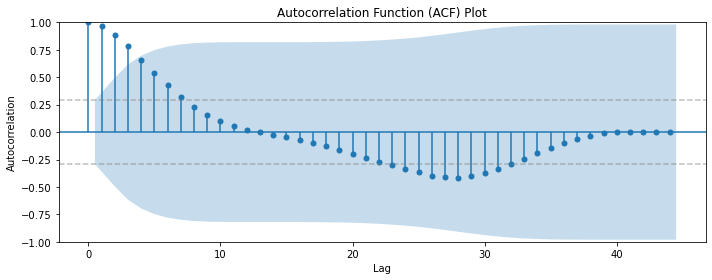

In [44]:
# Create the ACF plot
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(temp_series, lags=44, ax=ax)
ax.set_title('Autocorrelation Function (ACF) Plot')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

# Add confidence interval lines
conf_int = 1.96 / np.sqrt(len(temp_series))
ax.axhline(y=conf_int, linestyle='--', color='gray', alpha=0.5)
ax.axhline(y=-conf_int, linestyle='--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

In [46]:
model = ARIMA(train_el['Electricity_Price'], order=(12, 1, 4))  # Autogressive component is 4 (current value depends on past 12 months), Integrated Component 1 (seasonal data), Moving Average Component 1 (there are seasonal patterns with a period of 12 month)
results = model.fit()

/Users/william/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
# Forecast future electricity usage
forecast_horizon = 20  # forecast horizon (20 quarter)
forecast = results.forecast(steps=forecast_horizon)

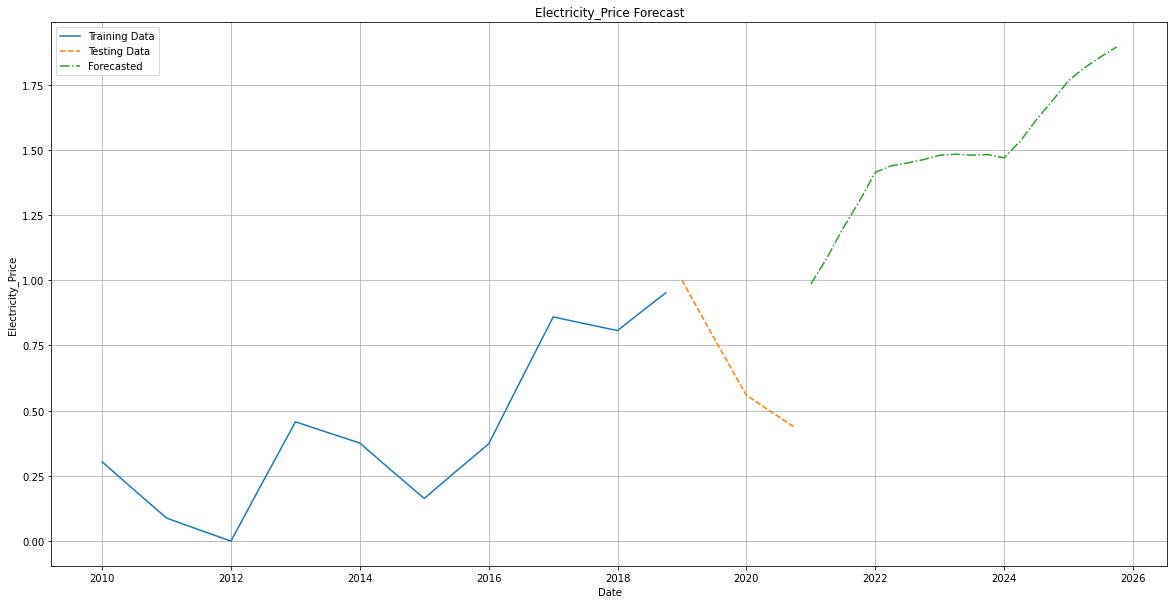

In [48]:
# Convert the 'quarter' column to datetime format with no timezone information
train_el['Time_Period'] = pd.to_datetime(train_el['Time_Period'], errors='coerce').dt.tz_localize(None)
test_el['Time_Period'] = pd.to_datetime(test_el['Time_Period'], errors='coerce').dt.tz_localize(None)

# Plot historical data, training data, and forecasted values
plt.figure(figsize=(20, 10))

plt.plot(train_el['Time_Period'], train_el['Electricity_Price'], label='Training Data')
plt.plot(test_el['Time_Period'], test_el['Electricity_Price'], label='Testing Data', linestyle='--')

# Define the start date for the forecasted period
start_date = test_el['Time_Period'].dropna().iloc[-1]  # Assuming 'quarter' column contains date values and handling missing values

# Plot the forecasted period with date values
forecast_dates = pd.date_range(start=start_date, periods=forecast_horizon+1, freq='QS')[1:]
plt.plot(forecast_dates, forecast, label='Forecasted', linestyle='-.')  # Use forecast_dates for x-axis

plt.xlabel('Date')
plt.ylabel('Electricity_Price')
plt.title('Electricity_Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
df_el=pd.DataFrame({'Time_Period':forecast_dates,'Electricity_Price':forecast})
df_el

,Time_Period,Electricity_Price
36,2021-01-01,0.985916
37,2021-04-01,1.084578
38,2021-07-01,1.197953
39,2021-10-01,1.300599
40,2022-01-01,1.413920
41,2022-04-01,1.438513
42,2022-07-01,1.449647
43,2022-10-01,1.462544
44,2023-01-01,1.479392
45,2023-04-01,1.483237


# Forecast Electricity Demand

## Merge 5 predicted datasets together


In [50]:
merged_df = df_pop.merge(df_coal, on='Time_Period')
merged_df = merged_df.merge(df_LPG, on='Time_Period')
merged_df = merged_df.merge(df_temp, on='Time_Period')
merged_df = merged_df.merge(df_el, on='Time_Period')
merged_df

,Time_Period,Population,Coal_Price,Automotive_LPG,Temperature_Avg,Electricity_Price
0,2021-01-01,0.892348,0.598256,0.742030,0.922754,0.985916
1,2021-04-01,0.918500,0.623917,0.454679,0.251412,1.084578
2,2021-07-01,0.945620,0.648405,0.383077,0.035320,1.197953
3,2021-10-01,0.970223,0.617756,0.359143,0.693964,1.300599
4,2022-01-01,0.993355,0.491422,0.264679,0.914457,1.413920
5,2022-04-01,1.015103,0.517375,0.106055,0.254401,1.438513
6,2022-07-01,1.035550,0.515945,0.138258,0.039832,1.449647
7,2022-10-01,1.054774,0.445549,0.243832,0.693737,1.462544
8,2023-01-01,1.072848,0.346872,0.258626,0.907952,1.479392
9,2023-04-01,1.089840,0.385020,0.233500,0.256117,1.483237


In [51]:
merged_input =merged_df.drop(['Time_Period'],axis=1)

In [52]:
features = ['Population',
 'Coal_Price',
 'Automotive_LPG',
 'Temperature_Avg',
 'Electricity_Price']
X_train, y_train, X_test, y_test = test_split(features)

In [53]:
X_train

,Population,Coal_Price,Automotive_LPG,Temperature_Avg,Electricity_Price
Time_Period,,,,,
2010-01-01,0.000000,0.558774,0.228571,0.999016,0.303922
2010-04-01,0.018352,0.632759,0.171429,0.279528,0.250000
2010-07-01,0.038033,0.564323,0.000000,0.135827,0.196078
2010-10-01,0.056494,0.719280,0.200000,0.670276,0.142157
2011-01-01,0.082599,1.000000,0.542857,0.981299,0.088235
2011-04-01,0.101900,0.907461,0.514286,0.199803,0.066176
2011-07-01,0.127057,0.904197,0.428571,0.076772,0.044118
2011-10-01,0.151292,0.833333,0.400000,0.687008,0.022059
2012-01-01,0.183469,0.807485,0.600000,0.884843,0.000000


In [54]:
# Applied Champion Model
gb_model = GradientBoostingRegressor(random_state=23, n_estimators=150, learning_rate=0.188, max_depth=3)

In [55]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.188, n_estimators=150,
                          random_state=23)

In [56]:
project_target=gb_model.predict(merged_input)

In [57]:
series=pd.Series(project_target)

In [58]:
df_ele_demand_forecast = series.to_frame(name='Electricity_Demand_Forecst')

In [59]:
# Generate sequence of dates 
start_date = '2021-01-01'
end_date = '2025-10-01'
freq = 'QS'  # Quarterly start frequency
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)

In [60]:
df_ele_demand_forecast['Time_Period'] = time_period[:len(df)]

In [61]:
df_ele_demand_forecast

,Electricity_Demand_Forecst,Time_Period
0,0.644903,2021-01-01
1,0.578692,2021-04-01
2,0.632948,2021-07-01
3,0.499809,2021-10-01
4,0.692112,2022-01-01
5,0.606122,2022-04-01
6,0.680803,2022-07-01
7,0.548729,2022-10-01
8,0.663142,2023-01-01
9,0.585857,2023-04-01


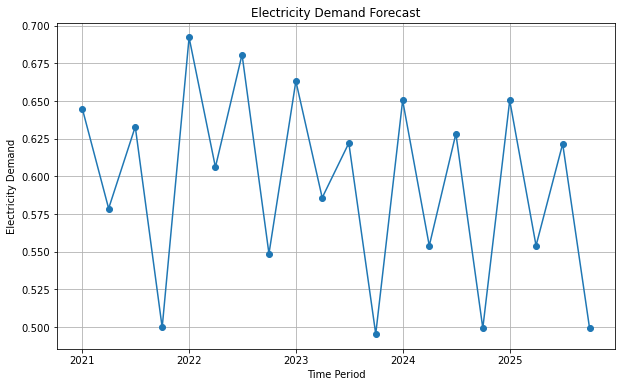

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(df_ele_demand_forecast['Time_Period'], df_ele_demand_forecast['Electricity_Demand_Forecst'], marker='o')
plt.xlabel('Time Period')
plt.ylabel('Electricity Demand')
plt.title('Electricity Demand Forecast')
plt.grid(True)

In [139]:
df = pd.read_csv(r'/Users/William/Documents/GitHub/ZZSC9020-Group-M/data/master_normalised.csv')
df= df.rename(columns={
     'quarter': "Time_Period",
     'Total Demand': "Electricity_Demand",
     'GDP (AUD, Millions)':"GDP",
     'Population (000,s)':"Population",
     'Coal_Price (PCOALAUUSDM)':"Coal_Price",
     'Premium unleaded petrol (95 RON) (cpl)':"Premium_Unleaded_Petrol",
     'Regular unleaded petrol (91 RON) (cpl)':"Regular_Unleaded_Petrol",
     'Automotive diesel (cpl)':"Automotive_Diesel",
     'Automotive LPG (cpl)':"Automotive_LPG",
     'Temperature(max)':"Temperature_Max",
     'Temperature(avg)':"Temperature_Avg",
     'Temperature(min)':"Temperature_Min",
     'electricity_price':"Electricity_Price",
     'renewable_energy':"Renewables_Production",
     'oil_price': 'Oil_Price'
})
df1=df[['Time_Period','Electricity_Demand']]
df1

,Time_Period,Electricity_Demand
0,2010-01-01,0.930894
1,2010-04-01,0.860334
2,2010-07-01,1.000000
3,2010-10-01,0.737070
4,2011-01-01,0.858217
5,2011-04-01,0.830642
6,2011-07-01,0.886552
7,2011-10-01,0.710198
8,2012-01-01,0.784999
9,2012-04-01,0.772382


In [140]:
df2=df_ele_demand_forecast[['Time_Period','Electricity_Demand_Forecst']]
df2

,Time_Period,Electricity_Demand_Forecst
0,2021-01-01,0.644903
1,2021-04-01,0.578692
2,2021-07-01,0.632948
3,2021-10-01,0.499809
4,2022-01-01,0.692112
5,2022-04-01,0.606122
6,2022-07-01,0.680803
7,2022-10-01,0.548729
8,2023-01-01,0.663142
9,2023-04-01,0.585857


In [141]:
# Stack the two DataFrames vertically
stacked_df = pd.concat([df1, df2], axis=0)

In [142]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
stacked_df

,Time_Period,Electricity_Demand,Electricity_Demand_Forecst
0,2010-01-01,0.930894,NaN
1,2010-04-01,0.860334,NaN
2,2010-07-01,1.000000,NaN
3,2010-10-01,0.737070,NaN
4,2011-01-01,0.858217,NaN
5,2011-04-01,0.830642,NaN
6,2011-07-01,0.886552,NaN
7,2011-10-01,0.710198,NaN
8,2012-01-01,0.784999,NaN
9,2012-04-01,0.772382,NaN


/var/folders/8w/t52xmc016gv90py0bf1sts940000gn/T/ipykernel_79167/2922374560.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Time_Period'] = pd.to_datetime(df1['Time_Period'])


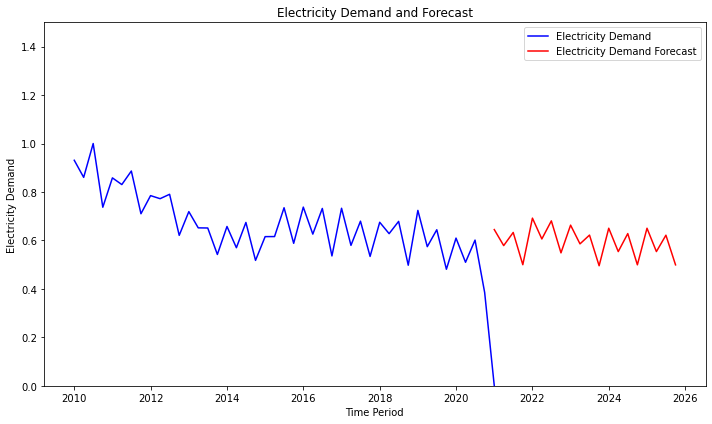

In [143]:
# Assuming you have two DataFrames: df1 and df2
# df1 contains 'time_period' and 'electricity_demand' columns
# df2 contains 'time_period' and 'electricity_demand_forecast' columns

# Convert 'time_period' column to datetime if it's not already
df1['Time_Period'] = pd.to_datetime(df1['Time_Period'])
df2['Time_Period'] = pd.to_datetime(df2['Time_Period'])

# Stack the two DataFrames vertically
stacked_df = pd.concat([df1, df2], axis=0)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot electricity_demand with blue color
ax.plot(df1['Time_Period'], df1['Electricity_Demand'], color='blue', label='Electricity Demand')

# Plot electricity_demand_forecast with red color
ax.plot(df2['Time_Period'], df2['Electricity_Demand_Forecst'], color='red', label='Electricity Demand Forecast')

# Set y-axis limits starting from 0 to max_y
ax.set_ylim(0, 1.5)

# Set labels and title
ax.set_xlabel('Time Period')
ax.set_ylabel('Electricity Demand')
ax.set_title('Electricity Demand and Forecast')

# Add legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [144]:
stacked_df 

,Time_Period,Electricity_Demand,Electricity_Demand_Forecst
0,2010-01-01,0.930894,NaN
1,2010-04-01,0.860334,NaN
2,2010-07-01,1.000000,NaN
3,2010-10-01,0.737070,NaN
4,2011-01-01,0.858217,NaN
5,2011-04-01,0.830642,NaN
6,2011-07-01,0.886552,NaN
7,2011-10-01,0.710198,NaN
8,2012-01-01,0.784999,NaN
9,2012-04-01,0.772382,NaN


In [145]:
from sklearn.preprocessing import MinMaxScaler
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
scaled_data = scaler.fit_transform(df[['Electricity_Demand']])  # Notice the double brackets to keep it as a DataFrame

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['Electricity_Demand_Scaled'])  # Provide column name for the scaled feature

# Now 'scaled_df' contains your scaled data in a DataFrame with a single feature column

# Revert the scaled data back to the original scale
original_data = scaler.inverse_transform(stacked_df)  # Reshape the scaled data before inverse transform

# Convert the original data back to a DataFrame
#original_df = pd.DataFrame(original_data, columns=['Electricity_Demand'])  # Provide column name for the original feature

# Now 'original_df' contains your dataset in its original scale

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [146]:
scaled_data 

array([[0.93089379],
       [0.86033381],
       [1.        ],
       [0.73706967],
       [0.85821693],
       [0.83064217],
       [0.88655199],
       [0.71019833],
       [0.7849993 ],
       [0.77238155],
       [0.79047465],
       [0.62102314],
       [0.71895135],
       [0.65193934],
       [0.65136269],
       [0.54208738],
       [0.65760319],
       [0.56995642],
       [0.67425582],
       [0.51773943],
       [0.61571971],
       [0.61600684],
       [0.73496661],
       [0.58809837],
       [0.73757749],
       [0.62610507],
       [0.73204841],
       [0.5360792 ],
       [0.73282318],
       [0.57967698],
       [0.67955438],
       [0.53401351],
       [0.67500306],
       [0.62802444],
       [0.67867526],
       [0.49771909],
       [0.72396688],
       [0.57432485],
       [0.64415115],
       [0.48107695],
       [0.60963554],
       [0.50987596],
       [0.60139663],
       [0.38499088],
       [0.        ]])